# About this notebook 
 ### This is beginner's room of pytorch BERT
 
 
 ### Rather than aiming for a score, I aim to:
 
*   Understanding deeply.
*   Natinal Language processing is performed in the same way as a neural network of numbers.
        
       If you have never built a pytorch neural network, this is recommended first. 
       
       https://www.kaggle.com/chumajin/pytorch-neural-network-starter-detail
       
       

      
        


*   Create a BERT template.
  

  ### I'm looking forward to helping you even a little. please upvote, thank you!
  ### Also, thank you for those who always upvote.
  
  ### The reference url in this notebook is mostly Japanese. If you are interested, please translate in your browser.  

--------That said, I couldn't publish it without getting a certain score, so here's a memo of the points I devised. --------

  (Although it is said to be for beginners, it is a maniac. I will explain it later.)
* I got a score using BertForSequenceClassification rather than using BertModel, so I chose it.
* Regarding the instability of Bert's fine-tuning, we adopted some parameters by referring to https://ai-scholar.tech/articles/bert/bert-fine-tuning.
* English page of this paper is https://arxiv.org/abs/2006.04884.

     
    ※　Since it takes time for 20 epoch and 5 k-folds in the Large-model, I adopted the base uncased model only there.

#### The number of epochs is set to 20 epoch when debug = False and 1 when True. If you want to know only the flow, please set it to True.

In [ ]:
debug = False

#### From ver 8, if you want to submit only this notebook, set debug2 to false. I'll omit some code. 

In [ ]:
debug2 = False

# 0. Preparation

In [ ]:
import numpy as np 
import pandas as pd 
import os
       
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt 

import transformers
import random


import warnings
warnings.simplefilter('ignore')

scaler = torch.cuda.amp.GradScaler() # Acceleration on GPU.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Automatically determine if cpu is gpu
device

#### Random seed fixation

In [ ]:
SEED = 533

def random_seed(SEED):
    
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(SEED)

# 1. EDA for this competition

In [ ]:
train = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
train.head(3)

In [ ]:
# 0th sentence example of excerpt
train.excerpt[0]

#### The difficulty level of the readability of excerpt sentences is entered in target, and it is a competition to predict it (very simple)

In [ ]:
test = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
test

#### The test has no target and standard error

In [ ]:
sample = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")
sample

#### Predict the target of test data and submit it as a submission file.

# 2. BERT: Deepen your understanding of Tokenizer
##      It makes English words id and various things

#### There are various models of bert, but this time I used bert-base-uncased.
#### There is also bert-large-uncased, but the number of dimensions of the embedded vector in BERT is different.
#### There is a bert-large-uncased on https://www.kaggle.com/xhlulu/huggingface-bert, so you can use it if you change the input there.

In [ ]:
# kaggle offline mode: submit is offline because internet is offline. It comes from the published dataset.
tokenizer = transformers.BertTokenizer.from_pretrained("../input/bert-base-uncased")

# Please use this when using online such as local PC.
# tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")


#### I will play around with id 0 using tokenizer.

In [ ]:
test_s = train["excerpt"].iloc[0]
test_s

#### ver 21 : remove \n in order to get better score.

In [ ]:
test_s = test_s.replace("\n","")
test_s

#### If you feed the tokenizer encode_plus without thinking about anything

In [ ]:
result1 = tokenizer.encode_plus(test_s)
result1

As the output of Tokenizer, it comes out in dictionary type, and there are the following three
* input_ids: Word id (the one in BERT's pretrained model) * In detail, 101 [CLS] and 102 [SEP] are added at the beginning and end.
* token_type_ids: Binary mask to grasp sentences: This time it is a regression problem, all 0. When looking at the connection between sentences, change it by inserting [SEP] etc. in the middle.
* attention_mask: Binary mask to judge embedding: For example, this time, we will substitute [PAD] to match the number of characters later, but we will judge it.
You may understand if you can see this person. https://qiita.com/omiita/items/72998858efc19a368e50  @ Japanese

#### Let's return to the sentence from the word id of input_ids.

In [ ]:
tokenizer.decode(result1["input_ids"])

#### You can see that [CLS] indicating the beginning and [SEP] indicating the end have been added.
#### These two are called Special tokens (default, which has the option of including or not including the tokenizer argument, is included).

## [Important] In BERT, it is necessary to have the same number of words in each sentence.


## (Max of pretrained model is 512)

#### First, let's count the number of words in the longest sentence in this train data. 
#### In ver19, in order to submit this notebook with avoiding time exceeding, I omit this part by debug2 = False. It will take some time.

In [ ]:
if debug2:
    sen_length = []

    for sentence in tqdm(train["excerpt"]):

        token_words = tokenizer.encode_plus(sentence)["input_ids"]
        sen_length.append(len(token_words))

    print('maxlenth of all sentences are  ', max(sen_length))

If debug2 is set to True, the following result will be displayed.

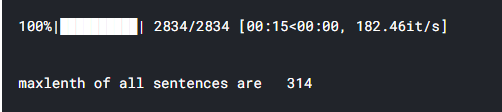

#### 314 words is the maximum number of words in this train data. However, it includes [CLS] and [SEP].

#### It is necessary to fill in less than 314 sentences with [PAD].

In [ ]:
test_s

In [ ]:
len(test_s.split(" "))

#### If you adjust the argument of tokenizer, it will be adjusted automatically.

In [ ]:
result2 = tokenizer.encode_plus(
    test_s,
    add_special_tokens = True, # Whether to insert [CLS], [SEP]
    max_length = 314, # Align the number of words using padding and transcription
    pad_to_max_length = True, # Put [PAD] in the blank area
    
    truncation = True # Cutout function. For example, max_length10 is a function that makes only the first 10 characters. I got an alert if I didn't put it in, so I'll put it in
)

In [ ]:
result2

#### A lot of 0s are added after 102 of input_ids. Attention_mask also has 0 added, although it was all 1 earlier.

#### Try to return to the sentence from the word id

In [ ]:
tokenizer.decode(result2["input_ids"])

#### It can be seen that [PAD] has been added to make the length of the sentences uniform.
#### 0 in Attention mask means to hide it and ignore it

#### When shortening the sentence (I may adjust this area if it takes a lot of calculation time. For example, try 10; some people use 256 for other notebooks.)

In [ ]:
result3 = tokenizer.encode_plus(
    test_s,
    add_special_tokens = True, # Whether to insert [CLS], [SEP]
    max_length = 10, # Align the number of words using padding and transcription
    pad_to_max_length = True, # Put [PAD] in the blank area
    
    truncation = True # Cutout function. For example, max_length10 is a function that makes only the first 10 characters. I got an alert if I didn't put it in, so I'll put it in
)

In [ ]:
result3

#### You can use it as it is

#### This time, we will use the maximum length of 314. (Hereafter, converted in Dataset)

In [ ]:
max_sens = 314

# 3. Preparation of Pytorch neural network
## 3.1 k-fold

https://www.kaggle.com/abhishek/step-1-create-folds


This person shares how to make it, but here we simply sort it in target order and divide it into 5 folds in order.

In [ ]:
train = train.sort_values("target").reset_index(drop=True)
train

In [ ]:
train["kfold"] = train.index % 5

In [ ]:
train

#### First, let's try and set kfold = 0 as validation and the others as train data. Note that it will be stuck without reset_index ().

In [ ]:
p_train = train[train["kfold"]!=0].reset_index(drop=True)
p_valid = train[train["kfold"]==0].reset_index(drop=True)

## 3.2 Build DataSet and DataLoader (same as Neural network that handles numbers)

In [ ]:
class BERTDataSet(Dataset):
    
    def __init__(self,sentences,targets):
        
        self.sentences = sentences
        self.targets = targets
        
    def __len__(self):
        
        return len(self.sentences)
    
    def __getitem__(self,idx):
        
        sentence = self.sentences[idx]
        sentence = sentence.replace("\n","")
        
        bert_sens = tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True, 
                                max_length = max_sens, # set 314 from above code
                                pad_to_max_length = True, 
                                return_attention_mask = True,
                                truncation = True)

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(bert_sens['token_type_ids'], dtype=torch.long)
     
            
        target = torch.tensor(self.targets[idx],dtype=torch.float)
        
        return {
                'ids': ids,
                'mask': mask,
                'token_type_ids': token_type_ids,
                'targets': target
            }

In [ ]:
train_dataset = BERTDataSet(p_train["excerpt"],p_train["target"])
valid_dataset = BERTDataSet(p_valid["excerpt"],p_valid["target"])

In [ ]:
train_dataset[0]

#### Make sure it's done properly

In [ ]:
train_batch = 16
valid_batch = 32

#### How to make a dataloader (pin_memory, num_worker, AMP that will come later) is explained here in an easy-to-understand manner.

https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587　 @ Japanese page


In [ ]:
train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=4,pin_memory=True)
valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch,shuffle = False,num_workers=4,pin_memory=True)

In [ ]:
for a in train_dataloader:
    print(a)
    break

#### Make sure it's done properly

# 4. BERT modeling

#### BERT has various pretrained models depending on the application

* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* BertForSequenceClassification
* BertForMultipleChoice
* BertForTokenClassification
* BertForQuestionAnswering

This page explains it.

https://kento1109.hatenablog.com/entry/2019/08/20/161936 @ Japanese

Frequently, you can hide a part of a sentence to make a prediction or judge whether there is a connection between sentences.


This time, I used BertForSequenceClassification.

* At first I was using BertModel, but I couldn't improve the score. .. ..
By default, there are two outputs so that they are classified into two, such as 0 and 1, but this time it is a regression problem, so I will set the output (num_labels) to 1.
If you want to have a classification problem, you should adjust here.

In [ ]:
model = transformers.BertForSequenceClassification.from_pretrained("../input/bert-base-uncased",num_labels=1)

In [ ]:
model.to(device)
model.train()

### The model input was output by tokenizer (word id (input_ids), attention_mask (mask))
In this case, token_type_id seems to be OK with or without it.

Take a look at the contents of output

In [ ]:
for a in train_dataloader:
    ids = a["ids"].to(device)
    mask = a["mask"].to(device)
    tokentype = a["token_type_ids"].to(device)
    
    output = model(ids,mask)
    break

In [ ]:
output

#### Guessed values are coming out properly. Where you want to use logits

In [ ]:
output["logits"]

In [ ]:
output["logits"].shape

#### Looking at the shape, 1 is superfluous, so if you use squeeze, it will cut 1

In [ ]:
output["logits"].squeeze(-1)

In [ ]:
output["logits"].squeeze(-1).shape

#### Therefore, output is used in this form.

In [ ]:
output = output["logits"].squeeze(-1)

# 5. Creating a function to train

#### Define optimizer
* This time, I tried various things and learned the importance of the learning rate (at first, the learning rate was too high, and all the results predicted by regression were the same value, or I got stuck for more than a day ... .)

* For the time being, this notebook has adopted some parameters for Bert's fine-tuning instability, with reference to https://ai-scholar.tech/articles/bert/bert-fine-tuning. English page of this paper is https://arxiv.org/abs/2006.04884.

* However, in the above literature, it is a story of bert-large-uncased. This time, it took too long to turn 5 k-fold 20 epoch, so I chose bert-base-uncased.

* It's fine, so if you want to use it for the time being, you can ignore it and just let it flow.

In [ ]:
from transformers import AdamW
LR=2e-5
optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2) 

#### The following is the learning rate scheduler built into the transformer (the learning rate changes with each step).
#### In the recommendation of the site above, at 20 epoch, at the first 10%, after reaching the target learning rate, it was said that it attenuates to 0, so I made it.

In [ ]:
from transformers import get_linear_schedule_with_warmup


epochs = 20

if debug:
    epochs = 1

train_steps = int(len(p_train)/train_batch*epochs)
print(train_steps)

num_steps = int(train_steps*0.1)

scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

#### It will take some time, but if you look at the transition of the learning rate for each iteration, it looks like this.
#### In ver19, in order to submit this notebook with avoiding time exceeding, I omit this part by debug2 = False. It will take some time.

In [ ]:
if debug2:

    le=[]
    train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=4,pin_memory=True)

    for b in tqdm(range(epochs)):

        for a in train_dataloader:
            break
            le.append(scheduler.get_last_lr())
            scheduler.step()

    x = np.arange(len(le))
    plt.plot(x,le)

As a reference, the results show like this.

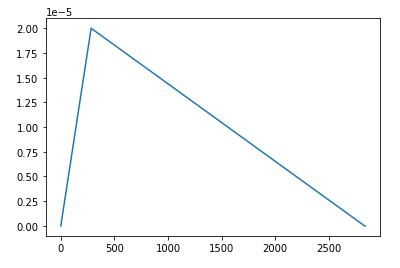

#### Since the loss function is RMSE this time, I defined it as follows.

In [ ]:
def loss_fn(output,target):
    return torch.sqrt(nn.MSELoss()(output,target))

#### Put the above optimizer and loss and make training a function.
#### I'm using AMD's autocast (), so I'm writing it that way.


https://qiita.com/Sosuke115/items/40265e6aaf2e414e2fea  @ Japanese

The image is easier to do here

https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587 @ Japanese

In [ ]:
def training(
    train_dataloader,
    model,
    optimizer,
    scheduler
):
    
    model.train()
    torch.backends.cudnn.benchmark = True

    allpreds = []
    alltargets = []

    for a in train_dataloader:

        losses = []

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():

            ids = a["ids"].to(device,non_blocking=True)
            mask = a["mask"].to(device,non_blocking=True)
            tokentype = a["token_type_ids"].to(device,non_blocking=True)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)

            target = a["targets"].to(device,non_blocking=True)

            loss = loss_fn(output,target)


            # For scoring
            losses.append(loss.item())
            allpreds.append(output.detach().cpu().numpy())
            alltargets.append(target.detach().squeeze(-1).cpu().numpy())

        scaler.scale(loss).backward() # backwards of loss
        scaler.step(optimizer) # Update optimizer
        scaler.update() # scaler update

        scheduler.step() # Update learning rate schedule
        
        del loss # effective for memory

        # Combine dataloader minutes

    allpreds = np.concatenate(allpreds)
    alltargets = np.concatenate(alltargets)

    # I don't use loss, but I collect it

    losses = np.mean(losses)

    # Score with rmse
    train_rme_loss = np.sqrt(mean_squared_error(alltargets,allpreds))

    return losses,train_rme_loss

#### 1epoch test 
#### In ver19, in order to submit this notebook with avoiding time exceeding, I omit this part by debug2 = False. It will take some time.

In [ ]:
if debug2:
    train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=4,pin_memory=True)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

    losses,train_rme_loss = training(train_dataloader,model,optimizer,scheduler)
    
    print(losses,train_rme_loss)

#### Also create validation version.

In [ ]:
def validating(
    valid_dataloader,
    model
):
    
    model.eval()

    allpreds = []
    alltargets = []

    for a in valid_dataloader:

        losses = []

        with torch.no_grad():

            ids = a["ids"].to(device,non_blocking=True)
            mask = a["mask"].to(device,non_blocking=True)
            tokentype = a["token_type_ids"].to(device,non_blocking=True)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)

            target = a["targets"].to(device,non_blocking=True)

            loss = loss_fn(output,target)


            # For scoring
            losses.append(loss.item())
            allpreds.append(output.detach().cpu().numpy())
            alltargets.append(target.detach().squeeze(-1).cpu().numpy())
            
            del loss


    # Combine dataloader minutes

    allpreds = np.concatenate(allpreds)
    alltargets = np.concatenate(alltargets)

    # I don't use loss, but I collect it

    losses = np.mean(losses)

    # Score with rmse
    valid_rme_loss = np.sqrt(mean_squared_error(alltargets,allpreds))

    return allpreds,losses,valid_rme_loss

In [ ]:
if debug2:
    allpreds,losses,valid_rme_loss = validating(valid_dataloader,model)
    print(allpreds[:3])
    print(losses)
    print(valid_rme_loss)

# 6. Do training

### I've done a lot for explanation, so I'll initialize the parameter.
### From ver 20, this method is using how to make repeatable results from my experiment. 
### Please see the this shared notebook https://www.kaggle.com/chumajin/how-to-initialize-the-code-correctly-english

In [ ]:
def initialize(fold):
    

    # initializing the data

    random_seed(SEED)

    p_train = train[train["kfold"]!=fold].reset_index(drop=True)
    p_valid = train[train["kfold"]==fold].reset_index(drop=True)


    train_dataset = BERTDataSet(p_train["excerpt"],p_train["target"])
    valid_dataset = BERTDataSet(p_valid["excerpt"],p_valid["target"])

    train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=4,pin_memory=True)
    valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch,shuffle = False,num_workers=4,pin_memory=True)

    model = transformers.BertForSequenceClassification.from_pretrained("../input/bert-base-uncased",num_labels=1)

    model.to(device)
    LR=2e-5
    optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2) # AdamW optimizer

    train_steps = int(len(p_train)/train_batch*epochs)

    num_steps = int(train_steps*0.1)

    scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)
    
    scaler = torch.cuda.amp.GradScaler() 
    
    return train_dataloader,valid_dataloader,model,optimizer,scheduler,scaler


In [ ]:
train_dataloader,valid_dataloader,model,optimizer,scheduler,scaler = initialize(0)

In [ ]:
trainlosses = []
vallosses = []
bestscore = None

trainscores = []
validscores = []

for epoch in tqdm(range(epochs)):
    
    print("---------------" + str(epoch) + "start-------------")
    
    trainloss,trainscore = training(train_dataloader,model,optimizer,scheduler)
    
    trainlosses.append(trainloss)
    trainscores.append(trainscore)
    
    print("trainscore is " + str(trainscore))
    
    preds,validloss,valscore=validating(valid_dataloader,model)
    
    vallosses.append(validloss)
    validscores.append(valscore)

    
    print("valscore is " + str(valscore))
    
    if bestscore is None:
        bestscore = valscore
        
        print("Save first model")
        
        state = {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        "bestscore":bestscore
                    }
            

        torch.save(state, "model0.pth")
        
    elif bestscore > valscore:
        
        bestscore = valscore
        
        print("found better point")
        
        state = {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        "bestscore":bestscore
                    }
            

        torch.save(state, "model0.pth")
        
    else:
        pass
    

In [ ]:
plt.scatter(p_valid["target"],preds)

In [ ]:
x = np.arange(epochs)
plt.plot(x,trainlosses)
plt.plot(x,vallosses)

In [ ]:
x = np.arange(epochs)
plt.plot(x,trainscores)
plt.plot(x,validscores)

In [ ]:
# For other k-fold
bestscores = []
bestscores.append(bestscore)

# 7. I will continue to turn other K-folds.

In [ ]:
for fold in range(1,5):
    

    
    train_dataloader,valid_dataloader,model,optimizer,scheduler,scaler = initialize(fold)


    trainlosses = []
    vallosses = []
    bestscore = None

    trainscores = []
    validscores = []

    for epoch in tqdm(range(epochs)):

        print("---------------" + str(epoch) + "start-------------")

        trainloss,trainscore = training(train_dataloader,model,optimizer,scheduler)

        trainlosses.append(trainloss)
        trainscores.append(trainscore)

        print("trainscore is " + str(trainscore))

        preds,validloss,valscore=validating(valid_dataloader,model)

        vallosses.append(validloss)
        validscores.append(valscore)


        print("valscore is " + str(valscore))

        if bestscore is None:
            bestscore = valscore

            print("Save first model")

            state = {
                            'state_dict': model.state_dict(),
                            'optimizer_dict': optimizer.state_dict(),
                            "bestscore":bestscore
                        }


            torch.save(state, "model" + str(fold) + ".pth")

        elif bestscore > valscore:

            bestscore = valscore

            print("found better point")

            state = {
                            'state_dict': model.state_dict(),
                            'optimizer_dict': optimizer.state_dict(),
                            "bestscore":bestscore
                        }


            torch.save(state, "model"+ str(fold) + ".pth")

        else:
            pass


    bestscores.append(bestscore)


In [ ]:
bestscores

In [ ]:
np.mean(bestscores)
print("my cv is " + str(np.mean(bestscores)))

# 8. inference
#### For commercials, I will score on this notebook, but it will take time to submit, so it is better to do it on another notebook.
#### ※　Because this notebook includes training, so it takes much more than inference only.

In [ ]:
import gc
del train_dataset,valid_dataset,train_dataloader,valid_dataloader,model,optimizer,scheduler,scaler
_ = gc.collect()

In [ ]:
test

#### Since it is an inference, there is no target, so I omitted it

In [ ]:
class BERTinfDataSet(Dataset):
    
    def __init__(self,sentences):
        
        self.sentences = sentences
       
        
    def __len__(self):
        
        return len(self.sentences)
    
    def __getitem__(self,idx):
        
        sentence = self.sentences[idx]
        
        sentence = sentence.replace("\n","")
        
        
        bert_sens = tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True, # [CLS],[SEP]
                                max_length = 314,
                                pad_to_max_length = True, # add padding to blank
                                truncation=True)

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(bert_sens['token_type_ids'], dtype=torch.long)
     
        
    
        
        return {
                'ids': ids,
                'mask': mask,
                'token_type_ids': token_type_ids,
                
            }

In [ ]:
test_dataset = BERTinfDataSet(test["excerpt"])

In [ ]:
test_batch = 32

In [ ]:
test_dataloader = DataLoader(test_dataset,batch_size=test_batch,shuffle = False,num_workers=4,pin_memory=True)

In [ ]:
model = transformers.BertForSequenceClassification.from_pretrained('../input/bert-base-uncased',num_labels=1)

#### Model Loading

In [ ]:
pthes = [os.path.join("./",s) for s in os.listdir("./") if ".pth" in s]
pthes

#### prediction function

In [ ]:
def predicting(
    test_dataloader,
    model,
    pthes
    
):

    allpreds = []
    
    for pth in pthes:
        
        state = torch.load(pth)
        
        model.load_state_dict(state["state_dict"])
        model.to(device)
        model.eval()
    
    
        preds = []
        allvalloss=0

        with torch.no_grad():


            for a in test_dataloader:



                ids = a["ids"].to(device)
                mask = a["mask"].to(device)
                tokentype = a["token_type_ids"].to(device)

               # output = model(ids,mask,tokentype)
                output = model(ids,mask)

                output = output["logits"].squeeze(-1)


                preds.append(output.cpu().numpy())

            preds = np.concatenate(preds)
            
            allpreds.append(preds)

    return allpreds

In [ ]:
allpreds = predicting(test_dataloader,model,pthes)

#### Avarage the 5 model and making submission.

In [ ]:
findf = pd.DataFrame(allpreds)
findf = findf.T

In [ ]:
findf

In [ ]:
finpred = findf.mean(axis=1)
finpred

In [ ]:
sample

In [ ]:
sample["target"] = finpred

In [ ]:
sample

In [ ]:
sample.to_csv("submission.csv",index = False)

# Thank you for watching so far!

# If you find it useful, I would appreciate it if you could upvote it.
## Also, I learned a lot from the people at each reference URL. thank you very much!

#### Google translate is amazing ... thank you for google.
#### And Thanks to the staff of this competition.

# This notebook has a sequel.
## please refer and I'm happy if you upvote.

1) why my score got worse from 0.528(ver6) to 0.546(ver15) and how I could improve it back to 0.528(ver19) in this notebook.

How to initialize the code correctly (English&日本語): https://www.kaggle.com/chumajin/how-to-initialize-the-code-correctly-english

2) BERT and RoBERTa were compared with various random seeds in this model.

BERT v.s. RoBERTa (English & 日本語) : https://www.kaggle.com/chumajin/bert-v-s-roberta-english/notebook#About-this-notebook